# Comparing VGG11 and VGG16 via Temperature Scaling and LRP Propagation

Both VGG11 and VGG16 are popular convolutional neural networks.  Their architectures differ only in that VGG16 has more weighted layers than VGG11.  However, the deeper layers of a network have the capacity to capture finer patterns in the dataset.  Therefore, VGG16 typically performs better on classification tasks than VGG11.  But, accuracy isn't the only metric with which we should judge a network.  In this report, I compare these two networks with two other metrics:  calibration and interpretability.  To test how well the networks are calibrated, I will be utilizing the techniques presented in "On the calibration of modern neural networks."  In this paper, the authors introduce temperature scaling as a method for calibration.  I compare how effective this method is on VGG11 and VGG16.  To measure the interpretability of the two networks, I will be using Layer-wise Relevance Propogation (LRP) as presented in "Layer-wise Relevance Propogation:  An overview."  LRP takes advantage of the conservation property that what is received by a neuron during backpropogation must be redistributed to the next layer in equal amount.  This property aids the construction of local propagation rules for passing the predictions back through the network.  Thus, a relevance map can be constructed for each layer highlighting the parts of the image that produced the prediction.  To carry out these experiments, I use the tiny ImageNet dataset.  This is a smaller version of ImageNet.  Each image is downsampled to 64x64 resolution, and only 200 classes are considered.  There are 100,000 training images and 5,000 validation images and 5,000 testing images.  I will start with pretrained networks, but I adjust the final layer to accomadate the fewer number of classes.

In [11]:
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
import cv2
import scipy.misc

## Building Dataset

In [2]:
#Functions for moving tensors/model to GPU

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()

In [3]:
#Function for loading data from tiny ImageNet file

def load_tiny_imagenet(path, wnids_path, resize='False', num_classes=200, dtype=np.float32):
    wnids_file = os.path.join(wnids_path, 'wnids' + str(num_classes) + '.txt')
    with open(os.path.join(path, wnids_file), 'r') as f:
        wnids = [x.strip() for x in f]

    wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}

    words_file = os.path.join(wnids_path, 'words' + str(num_classes) + '.txt')
    with open(os.path.join(path, words_file), 'r') as f:
        wnid_to_words = dict(line.split('\t') for line in f)
        for wnid, words in wnid_to_words.items():
            wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
    class_names = [wnid_to_words[wnid] for wnid in wnids]

    X_train = []
    y_train = []
    for i, wnid in enumerate(wnids):
        if (i + 1) % 20 == 0:
            print('loading training data for synset %d / %d' % (i + 1, len(wnids)))
        boxes_file = os.path.join(path, 'train', wnid, '%s_boxes.txt' % wnid)
        with open(boxes_file, 'r') as f:
            filenames = [x.split('\t')[0] for x in f]
        num_images = len(filenames)

        if resize.lower() == 'true':
            X_train_block = np.zeros((num_images, 3, 32, 32), dtype=dtype)
        else:
            X_train_block = np.zeros((num_images, 3, 64, 64), dtype=dtype)

        y_train_block = wnid_to_label[wnid] * np.ones(num_images, dtype=np.int64)
        for j, img_file in enumerate(filenames):
            img_file = os.path.join(path, 'train', wnid, 'images', img_file)
            img = cv2.imread(img_file)
            try:
                if resize.lower() == 'true':
                    img = scipy.misc.imresize(img, (32, 32, 3))
                if img.shape[2] == 2:

                    if resize.lower() == 'true':
                        img.shape = (32, 32, 1)
                    else:
                        img.shape = (64, 64, 1)
                X_train_block[j] = img.transpose(2, 0, 1)
            except:
                print('Something went wrong')

        X_train.append(X_train_block)
        y_train.append(y_train_block)

    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    with open(os.path.join(path, 'val', 'val_annotations.txt'), 'r') as f:
        img_files = []
        val_wnids = []
        for line in f:
            if line.split()[1] in wnids:
                img_file, wnid = line.split('\t')[:2]
                img_files.append(img_file)
                val_wnids.append(wnid)
        num_val = len(img_files)
        y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])

        if resize.lower() == 'true':
            X_val = np.zeros((num_val, 3, 32, 32), dtype=dtype)
        else:
            X_val = np.zeros((num_val, 3, 64, 64), dtype=dtype)

        for i, img_file in enumerate(img_files):
            img_file = os.path.join(path, 'val', 'images', img_file)
            img = cv2.imread(img_file)
            if resize.lower() == 'true':
                img = scipy.misc.imresize(img, (32, 32, 3))
            if img.shape[2] == 2:
                if resize.lower() == 'true':
                    img.shape = (32, 32, 1)
                else:
                    img.shape = (64, 64, 1)

            X_val[i] = img.transpose(2, 0, 1)

    return class_names, X_train, y_train, X_val, y_val

In [ ]:
!unzip tiny-imagenet-200\ \(2\).zip

In [5]:
class_names, X_train, y_train, X_val, y_val = load_tiny_imagenet('/content/tiny-imagenet-200', '/content/tiny-imagenet-200')

loading training data for synset 20 / 200
loading training data for synset 40 / 200
loading training data for synset 60 / 200
loading training data for synset 80 / 200
loading training data for synset 100 / 200
loading training data for synset 120 / 200
loading training data for synset 140 / 200
loading training data for synset 160 / 200
loading training data for synset 180 / 200
loading training data for synset 200 / 200


In [6]:
#Turn arrays of images into lists of images

X_train_list = []

for i in range(100000):
    X_train_list.append(X_train[i])

X_val_list = []

for i in range(X_val.shape[0]):
    X_val_list.append(X_val[i])

In [7]:
#Create Dataset

from PIL import Image

class TinyImageNet(torch.utils.data.Dataset):

    def __init__(self, X_data, Y_data, transform=None):
        self.X_data = X_data
        self.Y_data = torch.LongTensor(Y_data)
        self.transform = transform

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        x = self.X_data[idx]
        y = self.Y_data[idx]

        if self.transform:
            x = Image.fromarray(self.X_data[idx].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)
        return x, y

In [8]:
#Data transform

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
        ])

In [22]:
#Creating dataset/dataloaders

train_dataset = TinyImageNet(X_train_list, y_train, transform=data_transform)
train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

val_test_dataset = TinyImageNet(X_val_list, y_val, transform=data_transform)
val_dataset, test_dataset = random_split(val_test_dataset, [5000, 5000])

val_dl = DataLoader(val_dataset, batch_size = 128, shuffle=True, num_workers=0)
test_dl = DataLoader(test_dataset, batch_size = 128, shuffle=True, num_workers=0)

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

## Running Networks

In [10]:
#Class for keeping track of results

class ImageClassificationBase(nn.Module):   
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
#Functions for computing validation and test accuracy   

def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def test_accuracy(model, test_loader):
    corr = 0
    poss = 0
    confusion_matrix = np.zeros((200,200))
    model.eval()
    for batch in test_loader:
        images, labels = batch
        out = model(images)
        _, preds = torch.max(out, dim=1)
        t = torch.sum(preds == labels).item()
        poss += len(images)
        corr += t
        for y in range(len(preds)):
            confusion_matrix[preds[y].item()][labels[y].item()] += 1
    confusion_matrix = confusion_matrix.astype('int32')
    return corr/poss, confusion_matrix

#Functions for evaluating and fitting network

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [11]:
#Creating VGG11 network

class VGG11(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.vgg11(pretrained=True)
    def forward(self, xb):
        return self.network(xb)

In [12]:
#Creating VGG16 network

class VGG16(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.vgg16(pretrained=True)
    def forward(self, xb):
        return self.network(xb)

In [13]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001

In [2]:
model_vgg11 = VGG11() 

## freeze the layers
for param in model.network.parameters():
    param.requires_grad = False

# Modify the last layer
number_features = model.network.classifier[6].in_features
features = list(model.network.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, 200)])
model.network.classifier = torch.nn.Sequential(*features)

to_device(model, torch.device('cuda'))

In [3]:
#Running VGG11

results_vgg11 = fit(num_epochs, lr, model_vgg11, train_dl, val_dl, opt_func)

In [4]:
model_vgg16 = VGG16() 

## freeze the layers
for param in model_vgg16.network.parameters():
    param.requires_grad = False

# Modify the last layer
number_features = model_vgg16.network.classifier[6].in_features
features = list(model_vgg16.network.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, 200)])
model_vgg16.network.classifier = torch.nn.Sequential(*features)

to_device(model_vgg16, torch.device('cuda'))

In [5]:
#Running VGG16

results_vgg16 = fit(num_epochs, lr, model_vgg16, train_dl, val_dl, opt_func)

In [6]:
#Saving results

torch.save(model_vgg16.state_dict(), 'vgg16_3.pth')

import csv

keys = results_vgg16[0].keys()
with open('vgg16_results_3.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(results_vgg16)

In [7]:
#Saving results

torch.save(model_vgg11.state_dict(), 'vgg11.pth')
torch.save(model_vgg16.state_dict(), 'vgg16.pth')

import csv

keys = results_vgg11[0].keys()
with open('vgg11_results.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(results)
  
keys = results_vgg16[0].keys()
with open('vgg16_results.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(results)

In [15]:
#Loading results

df1 = pd.read_csv(r"C:\Users\nomda\vgg11_results.csv")
df2 = pd.read_csv(r"C:\Users\nomda\vgg16_results_3.csv")

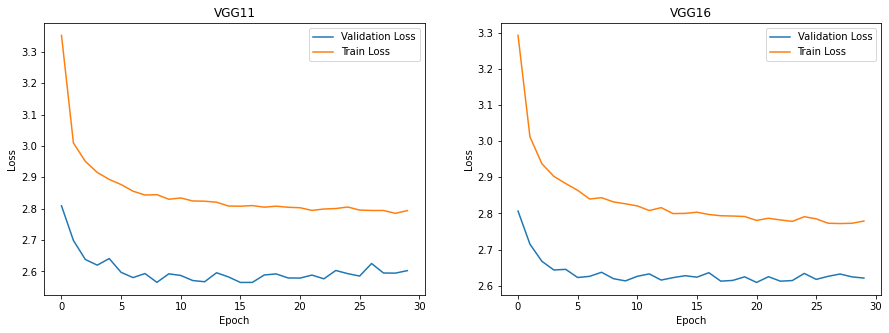

In [16]:
#Plotting validation and train loss

fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(range(30), df1['val_loss'], label="Validation Loss")
axs[0].plot(df1['train_loss'], label="Train Loss")
axs[0].set_title('VGG11')
axs[0].legend(loc='upper right')
axs[1].plot(range(30), df2['val_loss'], label="Validation Loss")
axs[1].plot(df2['train_loss'], label="Train Loss")
axs[1].set_title('VGG16')
axs[1].legend(loc='upper right')


for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Loss')

The losses for both networks are plotted above.  Both networks performed about the same.  Both could have benefitted from more training, as the training loss appears to still be slightly decreasing.  Due to time and resource constraints, this was not possible.  However, the losses are flat enough so that more training might bring about merely marginal improvements.

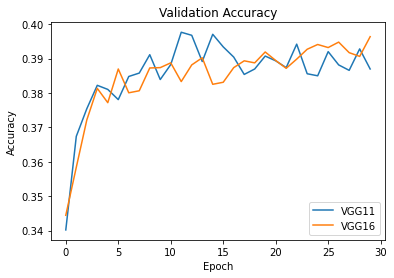

In [17]:
plt.plot(range(30), df1['val_acc'], label='VGG11')
plt.plot(df2['val_acc'], label='VGG16')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend(loc='lower right')
plt.show()

The validation accuracies are plotted above.  Again, the networks were comparable, though VGG16 seems to have less variability than VGG11.

In [18]:
accuracy_vgg11, confusion_matrix_vgg11 = test_accuracy(model_vgg11, test_dl)
accuracy_vgg16, confusion_matrix_vgg16 = test_accuracy(model_vgg16, test_dl)

In [ ]:
accuracy_vgg16

0.4074

In [ ]:
accuracy_vgg11

0.3894

VGG16 acchieved an accuracy that is about 2 percentage points better than VGG11.  

## Temperature Scaling

As discussed in "On the calibration of modern neural networks," many networks are poorly calibrated.  A network is poorly calibrated when the probabilities for the predictions do not match the true likelihoods.  To combat this phenomenon, the authors propose temperature scaling.  This method uses a single parameter, "temperature," to increase the entropy of the distribution over output classes.  The optimal temperature is calculated on the validation data after training is complete.  To calibrate the networks trained above, I use the implementation created by the authors of the paper and can be found here: https://github.com/gpleiss/temperature_scaling

In [17]:
from temperature_scaling import ModelWithTemperature

model_vgg11_temp = ModelWithTemperature(model_vgg11)
model_vgg11_temp.set_temperature(val_dl)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Before temperature - NLL: 3.513, ECE: 0.203
Optimal temperature: 1.563
After temperature - NLL: 3.125, ECE: 0.019


ModelWithTemperature(
  (model): VGG11(
    (network): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU(inplace=True)
        (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): ReLU(inplace=True)
        (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (9): ReLU(inplace=True)
        (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (12): ReLU(inplace=True)
        (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [18]:
model_vgg16_temp = ModelWithTemperature(model_vgg16)
model_vgg16_temp.set_temperature(val_dl)

Before temperature - NLL: 3.567, ECE: 0.211
Optimal temperature: 1.576
After temperature - NLL: 3.148, ECE: 0.024


ModelWithTemperature(
  (model): VGG16(
    (network): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=

The optimal temperatures for VGG11 and VGG16 are 1.563 and 1.576, respectively.  So, the temperatures for both networks are very similar.  Next, I compare the reliability diagrams of both original networks and the calibrated networks.  A reliability diagram compares the confidence of the predictions of the network with the accuracy of the network.  For a well calibrated network, the confidence and accuracy should be equal.  For example, if there are 100 images for which the network assigned a confidence between 0.2 and 0.3, then we should see that between 20 and 30 images are correctly classified.

In [19]:
def get_reliability_diagram(test_dload, model):
    bin_size = np.zeros((10,))
    acc_bins = np.zeros((10,))
    conf_bins = np.zeros((10,))
    bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    model.eval()
    for batch in test_dload:
        images, labels = batch
        probs, preds = torch.max(F.softmax(model(images)), dim=1)
        for i in range(images.size()[0]):
            bin_numb = None
            for j in range(10):
                if probs[i] - bins[9-j] > 0:
                    bin_size[9-j] += 1
                    conf_bins[9-j] += probs[i].item()
                    bin_numb = 9-j
                    break
            if preds[i] == labels[i]:
                acc_bins[bin_numb] += 1
    acc_bins = acc_bins / bin_size
    conf_bins = conf_bins / bin_size
    return acc_bins, conf_bins, bin_size



In [21]:
acc_bin_vgg11, conf_bin_vgg11, bin_size_11 = get_reliability_diagram(test_dl, model_vgg11)
acc_bin_vgg11_temp, conf_bin_vgg11_temp, bin_size_11_temp = get_reliability_diagram(test_dl, model_vgg11_temp)

acc_bin_vgg16, conf_bin_vgg16, bin_size_16 = get_reliability_diagram(test_dl, model_vgg16)
acc_bin_vgg16_temp, conf_bin_vgg16_temp, bin_size_16_temp = get_reliability_diagram(test_dl, model_vgg16_temp)


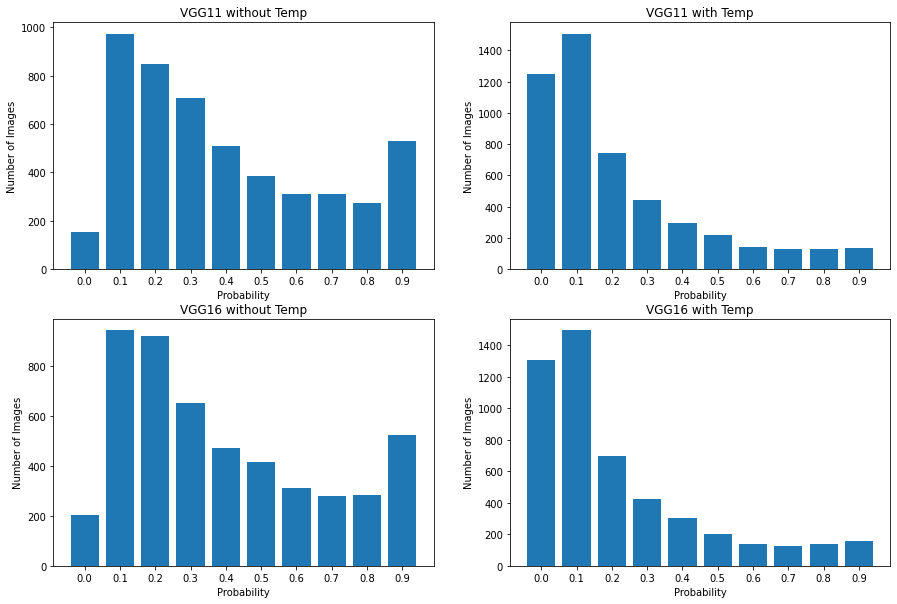

In [25]:
bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
fig, axs = plt.subplots(2, 2, figsize=(15,10))
axs[0,0].bar(range(10), bin_size_11)
axs[0,0].set_title('VGG11 without Temp')
axs[0,1].bar(range(10), bin_size_11_temp)
axs[0,1].set_title('VGG11 with Temp')
axs[1,0].bar(range(10), bin_size_16)
axs[1,0].set_title('VGG16 without Temp')
axs[1,1].bar(range(10), bin_size_16_temp)
axs[1,1].set_title('VGG16 with Temp')

for ax in axs.flat:
    ax.set(xlabel='Probability', ylabel='Number of Images', xticklabels=bins, xticks=range(10))

Above are barplots for each network showing the number of images assigned to each probability bin.  By adding temperature to the model, the confidence for many images was dramatically decreased.  It seems that this affect was about equal for both networks.

Next, I look at the reliability diagrams for each network.

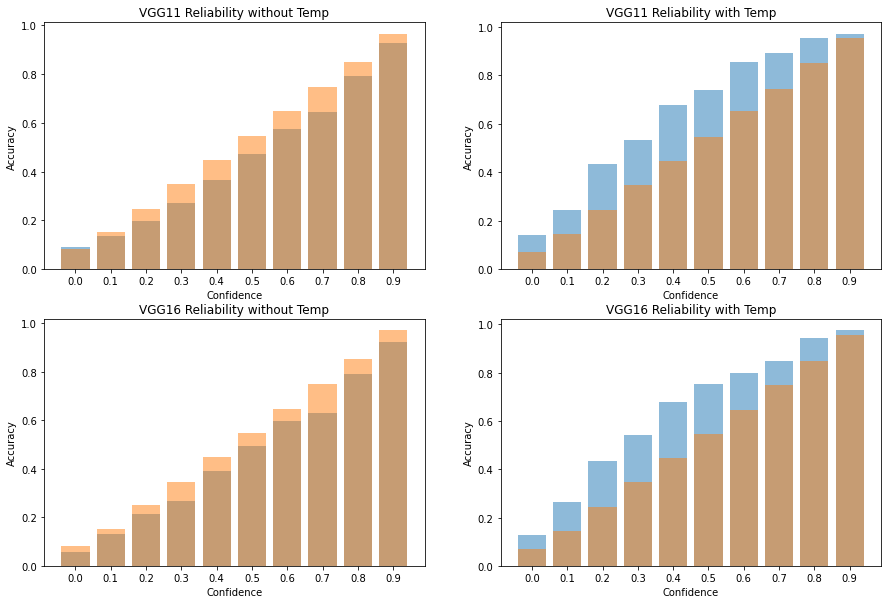

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))
axs[0,0].bar(range(10), acc_bin_vgg11, alpha=0.5)
axs[0,0].bar(range(10),conf_bin_vgg11, alpha=0.5)
axs[0,0].set_title('VGG11 Reliability without Temp')
axs[0,1].bar(range(10), acc_bin_vgg11_temp, alpha=0.5)
axs[0,1].bar(range(10),conf_bin_vgg11_temp, alpha=0.5)
axs[0,1].set_title('VGG11 Reliability with Temp')
axs[1,0].bar(range(10), acc_bin_vgg16, alpha=0.5)
axs[1,0].bar(range(10),conf_bin_vgg16, alpha=0.5)
axs[1,0].set_title('VGG16 Reliability without Temp')
axs[1,1].bar(range(10), acc_bin_vgg16_temp, alpha=0.5)
axs[1,1].bar(range(10),conf_bin_vgg16_temp, alpha=0.5)
axs[1,1].set_title('VGG16 Reliability with Temp')

for ax in axs.flat:
    ax.set(xlabel='Confidence', ylabel='Accuracy', xticklabels=bins, xticks=range(10))

The reliability diagrams for the networks are above.  It seems that before adding temperature, the networks were fairly well calibrated.  Adding temperature seems to have made things worse.  The affect again seems to be about equal for both networks, but may be a little less bad for VGG16.

## LRP

Finally, I will be comparing VGG11 and VGG16 using LRP.

In [422]:
#Adapted from the authors' tutorial found at https://git.tu-berlin.de/gmontavon/lrp-tutorial

import copy
from matplotlib.colors import ListedColormap

def heatmap(R,sx,sy):
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:,0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    return my_cmap, b

def newlayer(layer,g):
    layer = copy.deepcopy(layer)
    try: 
        layer.weight = nn.Parameter(g(layer.weight))
    except AttributeError: 
        pass
    try: 
        layer.bias = nn.Parameter(g(layer.bias))
    except AttributeError: 
        pass
    return layer

def toconv(layers):
    newlayers = []
    for i,layer in enumerate(layers):
        if isinstance(layer,nn.Linear):
            newlayer = None
            if i == 0:
                m,n = 512,layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,7)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,7,7))
            else:
                m,n = layer.weight.shape[1],layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,1)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,1,1))
            newlayer.bias = nn.Parameter(layer.bias)
            newlayers += [newlayer]
        else:
            newlayers += [layer]
    return newlayers


def apply_rules(A, L, T, layers, vgg_numb, temp):
    R = [None]*L + [((A[-1]/temp).cuda()*T.cuda()).data]
    for l in range(1,L)[::-1]:
        A[l] = (A[l].data).requires_grad_(True)
        if isinstance(layers[l],torch.nn.MaxPool2d): 
            layers[l] = torch.nn.AvgPool2d(2)
        if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):
            if l <= 11+vgg_numb:
                rho = lambda p: p + 0.25*p.clamp(min=0)
                incr = lambda z: z+1e-9
            if 12+vgg_numb <= l <= 25+vgg_numb: 
                rho = lambda p: p
                incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
            if l >= 26+vgg_numb:
                rho = lambda p: p
                incr = lambda z: z+1e-9
            z = incr(newlayer(layers[l],rho).forward(A[l]))        # step 1
            s = (R[l+1]/z).data                                    # step 2
            (z*s).sum().backward(); c = A[l].grad                  # step 3
            R[l] = (A[l]*c).data                                   # step 4   
        else:  
          R[l] = R[l+1]
    return R

def get_lrp(model, X, vgg_numb, temp_scale):
    m = model
    if temp_scale:
        m = model.model
    layers = list(m.network._modules['features']) + toconv(list(m.network._modules['classifier']))
    L = len(layers)
    A = [X]+[None]*L
    for l in range(L): 
        A[l+1] = layers[l].forward(A[l])
    scores = np.array(A[-1].cpu().data.view(-1))
    temp = 1
    if temp_scale:
        temp = model.temperature.item()
        scores = scores / temp
    ind = np.argsort(-scores)
    T = torch.FloatTensor((1.0*(np.arange(200)==ind[0]).reshape([1,200,1,1])))
    return apply_rules(A, L, T, layers, vgg_numb, temp)


In [250]:
#Collecting sample images for visualization

sample_images = []
for batch in test_dl:
    images, labels = batch
      for i in range(40):
        sample_images.append((images[i], labels[i]))
    break


In [436]:
#Function for creating figure

def create_figure(idx):
    image = sample_images[idx][0].unsqueeze(0)
    vgg11_rel = get_lrp(model_vgg11, image, 0, False)
    vgg11_prob, vgg11_pred = torch.max(F.softmax(model_vgg11(image.cuda()), dim=1), dim=1)
    vgg11_rel_temp = get_lrp(model_vgg11_temp, image, 0, True)
    vgg11_temp_prob, vgg11_temp_pred = torch.max(F.softmax(model_vgg11_temp(image.cuda()), dim=1), dim=1)
    vgg16_rel = get_lrp(model_vgg16, image, 5, False)
    vgg16_prob, vgg16_pred = torch.max(F.softmax(model_vgg16(image.cuda()), dim=1), dim=1)
    vgg16_rel_temp = get_lrp(model_vgg16_temp, image, 5, True)
    vgg16_temp_prob, vgg16_temp_pred = torch.max(F.softmax(model_vgg16_temp(image.cuda()), dim=1), dim=1)
    fig = plt.figure(figsize=(20, 25))
    a = fig.add_subplot(5, 5, 1)
    a.set_title("VGG11 Relevance")
    a_xlabel = "Prediction: " + class_names[vgg11_pred][0] + "  Prob:" + str(round(vgg11_prob.item(), 2))
    a.set_xlabel(a_xlabel)
    my_cmap, b = heatmap(np.array(vgg11_rel[1][0].cpu()).sum(axis=0),0.5*2+1.5,0.5*2+1.5)
    plt.imshow(np.array(vgg11_rel[1][0].cpu()).sum(axis=0),cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
    aa = fig.add_subplot(5, 5, 2)
    aa.set_title("VGG11 with Temp Relevance")
    aa_xlabel = "Prediction: " + class_names[vgg11_temp_pred][0] + "  Prob:" + str(round(vgg11_temp_prob.item(), 2))
    aa.set_xlabel(aa_xlabel)
    my_cmap, b = heatmap(np.array(vgg11_rel_temp[1][0].cpu()).sum(axis=0),0.5*2+1.5,0.5*2+1.5)
    im1 = plt.imshow(np.array(vgg11_rel_temp[1][0].cpu()).sum(axis=0),cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
    c = fig.add_subplot(5, 5, 3)
    im = plt.imshow(image.squeeze(0).cpu().permute(1,2,0))
    c.set_title("Original Image")
    c_xlabel = "Label: " + class_names[sample_images[idx][1]][0]
    c.set_xlabel(c_xlabel)
    aaa = fig.add_subplot(5, 5, 4)
    aaa.set_title("VGG16 Relevance")
    aaa_xlabel = "Prediction: " + class_names[vgg16_pred][0] + "  Prob:" + str(round(vgg16_prob.item(), 2))
    aaa.set_xlabel(aaa_xlabel)
    my_cmap, b = heatmap(np.array(vgg16_rel[1][0].cpu()).sum(axis=0),0.5*2+1.5,0.5*2+1.5)
    im = plt.imshow(np.array(vgg16_rel[1][0].cpu()).sum(axis=0),cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
    aaaa = fig.add_subplot(5, 5, 5)
    aaaa.set_title("VGG16 with Temp Relevance")
    aaaa_xlabel = "Prediction: " + class_names[vgg16_temp_pred][0] + "  Prob:" + str(round(vgg16_temp_prob.item(), 2))
    aaaa.set_xlabel(aaaa_xlabel)
    my_cmap, b = heatmap(np.array(vgg16_rel_temp[1][0].cpu()).sum(axis=0),0.5*2+1.5,0.5*2+1.5)
    im = plt.imshow(np.array(vgg16_rel_temp[1][0].cpu()).sum(axis=0),cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')



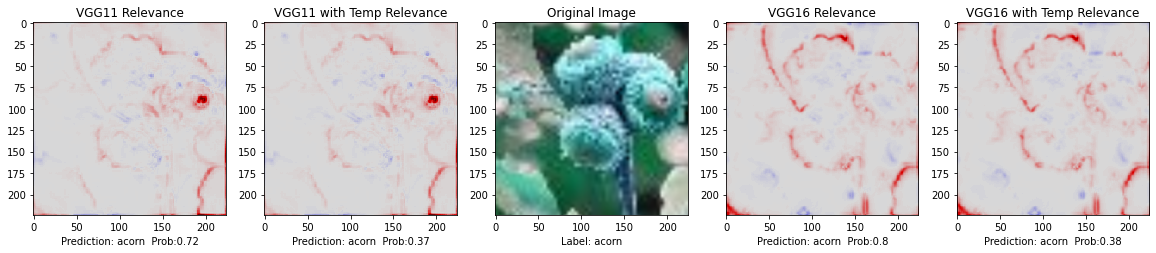

In [437]:
create_figure(10)

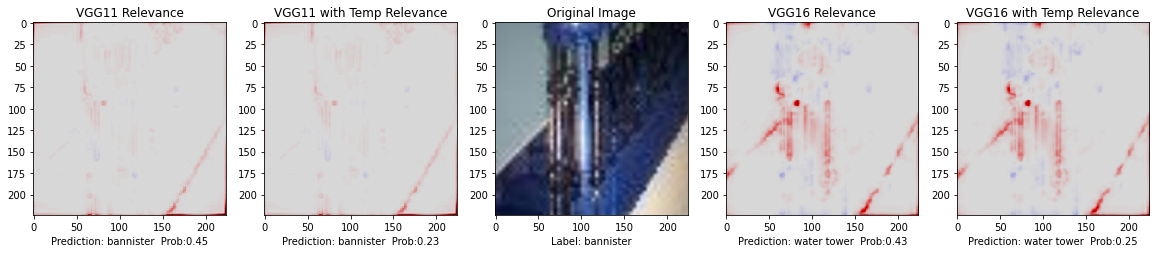

In [439]:
create_figure(21)

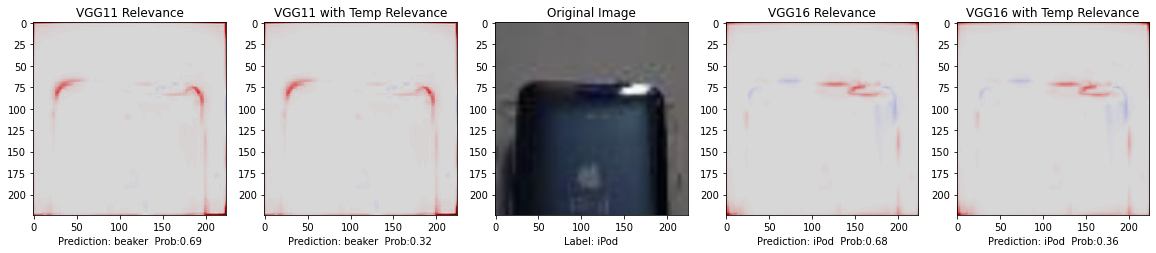

In [441]:
create_figure(31)

Above are three example visualizations.  The relevance maps displayed are from the last layers of each network.  Red indicates that the region positively affected the prediction, while blue indicates the region negatively affected the region.  In every case, we can see that VGG16 positively identifies more of the subject of the image than VGG11.  This is reflected in the fact that VGG16 assigns higher probabilities to the prediction.  Interestingly, even though VGG16 identified more of the bannister, it incorrectly predicted the image.  The difference between having temperature and not having temperature appears to be negligible, but it is possible that it is having an affect that is too subtle to be visualized.  Therefore, I next use 400 test images to compute some statistics on the relevance maps.

In [284]:
rel_dataset, _ = random_split(test_dataset, [400, 4600])
rel_dl = DataLoader(rel_dataset, batch_size=128)
rel_dl = DeviceDataLoader(rel_dl, device)

def get_relevance(model, test_dl, vgg_numb, temp_scale):
    df_rel = pd.DataFrame({"Relevance Mean": [],
                    "Relevance SD": [],
                   "Label": [],
                   "Prediction": [],
                   "Probability": [],
                   "Original Image": [],
                   "Correct": [],
                   })
  
    for batch in test_dl:
        images, labels = batch
        model.eval()
        out = model(images)
        _, preds = torch.max(out, dim=1)
        probs = torch.max(F.softmax(out, dim=1), dim=1)[0]
        for i in range(images.size()[0]):
            if i%10 == 0:  print(i);
            rel = get_lrp(model, images[i].unsqueeze(0), vgg_numb, temp_scale)
            new_row = {"Relevance Mean": torch.mean(rel[1]).item(),
                      "Relevance SD": torch.std(rel[1]).item(),
                      "Label": labels[i].item(),
                     "Prediction": preds[i].item(),
                     "Probability": probs[i].item(),
                     "Original Image": images[i].cpu(),
                     "Correct": (labels[i] == preds[i]).item()}
            df_rel = df_rel.append(new_row, ignore_index=True)
    return df_rel
      

In [22]:
df_vgg11_rel = get_relevance(model_vgg11, rel_dl, 0, False)
df_vgg11_rel_temp = get_relevance(model_vgg11_temp, rel_dl, 0, True)
df_vgg16_rel = get_relevance(model_vgg16, rel_dl, 5, False)
df_vgg16_rel_temp = get_relevance(model_vgg16_temp, rel_dl, 5, True)

In [313]:
df1 = df_vgg11_rel[df_vgg11_rel["Correct"]==1.0]
df2 = df_vgg11_rel[df_vgg11_rel["Correct"]==0.0]
df3 = df_vgg11_rel_temp[df_vgg11_rel["Correct"]==1.0]
df4 = df_vgg11_rel_temp[df_vgg11_rel["Correct"]==0.0]
df5 = df_vgg16_rel[df_vgg11_rel["Correct"]==1.0]
df6 = df_vgg16_rel[df_vgg11_rel["Correct"]==0.0]
df7 = df_vgg16_rel_temp[df_vgg11_rel["Correct"]==1.0]
df8 = df_vgg16_rel_temp[df_vgg11_rel["Correct"]==0.0]



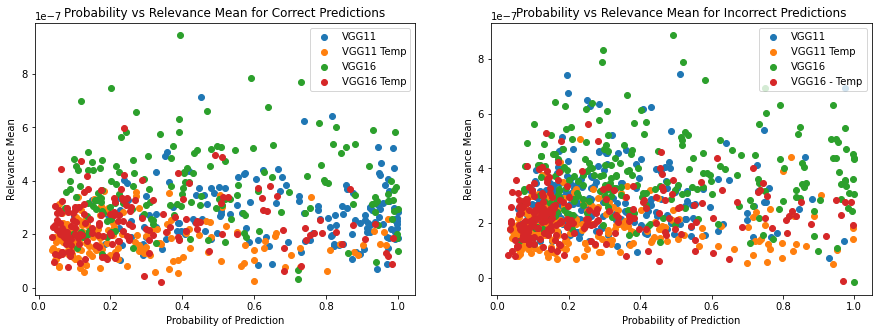

In [329]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].scatter(df1["Probability"], df1["Relevance Mean"], label="VGG11")
axs[0].scatter(df3["Probability"], df3["Relevance Mean"], label="VGG11 Temp")
axs[0].scatter(df5["Probability"], df5["Relevance Mean"], label="VGG16")
axs[0].scatter(df7["Probability"], df7["Relevance Mean"], label="VGG16 Temp")
axs[0].set_title("Probability vs Relevance Mean for Correct Predictions")
axs[0].set_xlabel("Probability of Prediction")
axs[0].set_ylabel("Relevance Mean")
axs[0].legend()
axs[1].scatter(df2["Probability"], df2["Relevance Mean"], label="VGG11")
axs[1].scatter(df4["Probability"], df4["Relevance Mean"], label="VGG11 Temp")
axs[1].scatter(df6["Probability"], df6["Relevance Mean"], label="VGG16")
axs[1].scatter(df8["Probability"], df8["Relevance Mean"], label="VGG16 - Temp")
axs[1].set_title("Probability vs Relevance Mean for Incorrect Predictions")
axs[1].set_xlabel("Probability of Prediction")
axs[1].set_ylabel("Relevance Mean")
axs[1].legend()

fig.show()


Above are scatter plots comparing the probability of the prediction and the mean of the relevance map.  For the correctly assigned predictions, there seems to be a lot less variance in the means.  Overall, the correctly assigned images have lower means.  In both cases, the means are more tightly clustered for probabilities between 0 and 0.2.  It seems that VGG16 with temperature is more tightly clustered than the rest, while VGG16 without temperature is the most scattered.  With both VGG16 and VGG11 it appears that temperature has resulted in lower means.  This may indicate that adding temperature results in less of the subject of the image being identified.

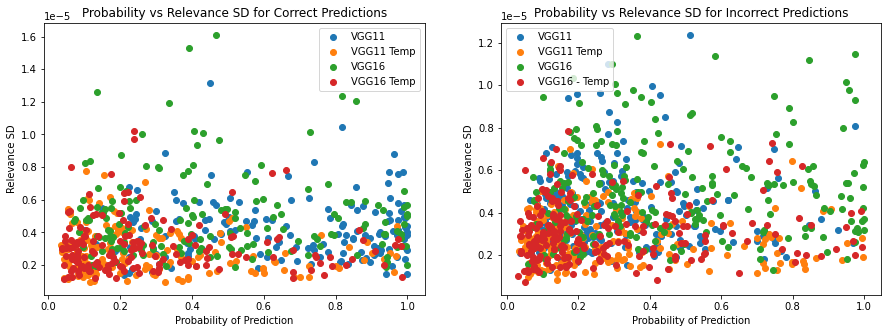

In [440]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].scatter(df1["Probability"], df1["Relevance SD"], label="VGG11")
axs[0].scatter(df3["Probability"], df3["Relevance SD"], label="VGG11 Temp")
axs[0].scatter(df5["Probability"], df5["Relevance SD"], label="VGG16")
axs[0].scatter(df7["Probability"], df7["Relevance SD"], label="VGG16 Temp")
axs[0].set_title("Probability vs Relevance SD for Correct Predictions")
axs[0].set_xlabel("Probability of Prediction")
axs[0].set_ylabel("Relevance SD")
axs[0].legend()
axs[1].scatter(df2["Probability"], df2["Relevance SD"], label="VGG11")
axs[1].scatter(df4["Probability"], df4["Relevance SD"], label="VGG11 Temp")
axs[1].scatter(df6["Probability"], df6["Relevance SD"], label="VGG16")
axs[1].scatter(df8["Probability"], df8["Relevance SD"], label="VGG16 - Temp")
axs[1].set_title("Probability vs Relevance SD for Incorrect Predictions")
axs[1].set_xlabel("Probability of Prediction")
axs[1].set_ylabel("Relevance SD")
axs[1].legend()

fig.show()


Above, the standard deviation of the relevance maps are plotted.  The standard deviation appears to be low and more tightly clustered when the probabilities are low.  There are many fewer cases of high standard deviations for the maps of correctly predicted images.  Again, VGG16 with temperature tends to have lower standard deviations than the other networks.  Also again, VGG16 without temperature has much more scattered deviations.  VGG11 with and without temperature performed similarly.

## Conclusions

In conclusion, we saw how VGG16 was more accurate than VGG11 on the tiny ImageNet dataset.  Both networks were about equally well calibrated before adding temperature.  Surprisingly, adding temperature resulted in worse calibration for both networks.  By comparing the relevance maps from LRP, we saw how VGG16 was able to utilize more of the subject of the image for prediction.  By comparing the statistics of the relevance maps, we saw how the models with temperature had lower means and standard deviations, indicating that perhaps the relevance maps for these networks didn't identify the subject of the images as clearly as the networks without temperature.  Overall, adding temperature resulted in both worse calibration and interpretability.